In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve


In [ ]:


path = "/content/drive/My Drive/credit-risk-project/DATA/accepted_2007_to_2018Q4.csv.gz"

df = pd.read_csv(path, compression="gzip", low_memory=False)
df.shape


(2260701, 151)

Keep only relevant columns for modelling

In [ ]:
selected_features = [
    "loan_amnt", "funded_amnt", "funded_amnt_inv",
    "term", "int_rate", "installment",
    "annual_inc", "dti",
    "delinq_2yrs", "inq_last_6mths", "open_acc",
    "total_acc", "revol_util", "revol_bal",
    "home_ownership", "verification_status", "purpose",
    "sub_grade", "emp_length",
    "loan_status"
]


In [ ]:
df = df[selected_features].copy()



Create Binary Default Flag


In [ ]:
default_conditions = ["Charged Off", "Default"]
resolved_statuses = ["Fully Paid", "Charged Off", "Default"]

df = df[df["loan_status"].isin(resolved_statuses)]

df["default_flag"] = df["loan_status"].apply(
    lambda x: 1 if x in default_conditions else 0
)


Drop Loan Status

In [ ]:
df = df.drop(columns=["loan_status"])


Clean EMP_LENGTH

In [ ]:
def clean_emp_length(x):
    if pd.isna(x):
        return np.nan

    x = str(x).lower().strip()

    if x in ["n/a", "na", "unknown", "", "none"]:
        return np.nan

    if "10" in x:
        return 10
    if "<" in x:
        return 0
    if "year" in x:
        num = ''.join([c for c in x if c.isdigit()])
        return int(num) if num else np.nan

    return np.nan


In [ ]:
df["emp_length"] = df["emp_length"].apply(clean_emp_length)


Clean Percentages and missing values

In [ ]:
df[["revol_util", "int_rate"]].dtypes


,0
revol_util,float64
int_rate,float64


In [ ]:
df["revol_util"] = (
    df["revol_util"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .replace("nan", np.nan)
    .astype(float)
)

df["int_rate"] = (
    df["int_rate"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .replace("nan", np.nan)
    .astype(float)
)


In [ ]:
df[["revol_util", "int_rate"]].describe()


,revol_util,int_rate
count,1.344493e+06,1.345350e+06
mean,5.180978e+01,1.323971e+01
std,2.452110e+01,4.768782e+00
min,0.000000e+00,5.310000e+00
25%,3.340000e+01,9.750000e+00
50%,5.220000e+01,1.274000e+01
75%,7.070000e+01,1.599000e+01
max,8.923000e+02,3.099000e+01


In [ ]:
df["revol_util"] = df["revol_util"].clip(upper=150)


In [ ]:
df["revol_util"].describe()


,revol_util
count,1.344493e+06
mean,5.180888e+01
std,2.450831e+01
min,0.000000e+00
25%,3.340000e+01
50%,5.220000e+01
75%,7.070000e+01
max,1.500000e+02


In [ ]:
df.isna().sum().sort_values(ascending=False).head(10)


,0
emp_length,78516
revol_util,857
dti,374
inq_last_6mths,1
term,0
funded_amnt_inv,0
funded_amnt,0
loan_amnt,0
annual_inc,0
delinq_2yrs,0


Imputation
Step 1: Impute numeric variables

In [ ]:
df["emp_length"] = df["emp_length"].fillna(df["emp_length"].median())
df["revol_util"] = df["revol_util"].fillna(df["revol_util"].median())
df["dti"] = df["dti"].fillna(df["dti"].median())
df["inq_last_6mths"] = df["inq_last_6mths"].fillna(0)


Step 2: Sanity Check

In [ ]:
df.isna().sum().sum()


np.int64(0)

Step 3: Define X and y

In [ ]:
X = df.drop(columns=["default_flag"])
y = df["default_flag"]


Step 4:  Creation of Modeling Base Table (`df_step1`)

Before applying Weight of Evidence (WOE) encoding, a clean modeling base table
is constructed.

This table:
- Contains the binary target variable (`default_flag`)
- Includes only candidate predictor variables available at or before loan origination
- Excludes post-outcome, performance, or leakage-prone fields
- Serves as the single source of truth for downstream modeling

This step mirrors how production credit risk datasets are prepared in practice.


4a. Define Candidate Predictor Variables

In [ ]:
candidate_features = [
    # Loan characteristics
    "loan_amnt",
    "term",
    "int_rate",
    "installment",
    "grade",
    "sub_grade",

    # Borrower capacity
    "annual_inc",
    "dti",
    "emp_length",
    "verification_status",
    "home_ownership",

    # Credit history
    "fico_range_low",
    "fico_range_high",
    "earliest_cr_line",
    "open_acc",
    "pub_rec",
    "revol_bal",
    "revol_util",
    "total_acc",
    "inq_last_6mths",
    "delinq_2yrs",

    # Purpose / structure
    "purpose",
    "addr_state",
    "application_type",

    # Time reference (used later for validation, not modeling)
    "issue_d"
]


4b. Next we keep products that exist in the dataset

In [ ]:
existing_features = [c for c in candidate_features if c in df.columns]

missing_features = sorted(set(candidate_features) - set(existing_features))

print("Included features:", existing_features)
print("Missing features:", missing_features)


Included features: ['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'emp_length', 'verification_status', 'home_ownership', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'inq_last_6mths', 'delinq_2yrs', 'purpose']
Missing features: ['addr_state', 'application_type', 'earliest_cr_line', 'fico_range_high', 'fico_range_low', 'grade', 'issue_d', 'pub_rec']


4c. Create df_step1

In [ ]:
df_step1 = df[existing_features + ["default_flag"]].copy()

print(df_step1.shape)
df_step1.head()


(1345350, 18)


,loan_amnt,term,int_rate,installment,sub_grade,annual_inc,dti,emp_length,verification_status,home_ownership,open_acc,revol_bal,revol_util,total_acc,inq_last_6mths,delinq_2yrs,purpose,default_flag
0,3600.0,36 months,13.99,123.03,C4,55000.0,5.91,10.0,Not Verified,MORTGAGE,7.0,2765.0,29.7,13.0,1.0,0.0,debt_consolidation,0
1,24700.0,36 months,11.99,820.28,C1,65000.0,16.06,10.0,Not Verified,MORTGAGE,22.0,21470.0,19.2,38.0,4.0,1.0,small_business,0
2,20000.0,60 months,10.78,432.66,B4,63000.0,10.78,10.0,Not Verified,MORTGAGE,6.0,7869.0,56.2,18.0,0.0,0.0,home_improvement,0
4,10400.0,60 months,22.45,289.91,F1,104433.0,25.37,3.0,Source Verified,MORTGAGE,12.0,21929.0,64.5,35.0,3.0,1.0,major_purchase,0
5,11950.0,36 months,13.44,405.18,C3,34000.0,10.20,4.0,Source Verified,RENT,5.0,8822.0,68.4,6.0,0.0,0.0,debt_consolidation,0


Basic Sanity Checks

In [ ]:
df_step1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1345350 entries, 0 to 2260697
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1345350 non-null  float64
 1   term                 1345350 non-null  object 
 2   int_rate             1345350 non-null  float64
 3   installment          1345350 non-null  float64
 4   sub_grade            1345350 non-null  object 
 5   annual_inc           1345350 non-null  float64
 6   dti                  1345350 non-null  float64
 7   emp_length           1345350 non-null  float64
 8   verification_status  1345350 non-null  object 
 9   home_ownership       1345350 non-null  object 
 10  open_acc             1345350 non-null  float64
 11  revol_bal            1345350 non-null  float64
 12  revol_util           1345350 non-null  float64
 13  total_acc            1345350 non-null  float64
 14  inq_last_6mths       1345350 non-null  float64
 15  del

In [ ]:
df_step1["default_flag"].value_counts(normalize=True)


,proportion
default_flag,
0,0.80035
1,0.19965


In [ ]:
df_step1.isna().mean().sort_values(ascending=False).head(10)


,0
loan_amnt,0.0
term,0.0
int_rate,0.0
installment,0.0
sub_grade,0.0
annual_inc,0.0
dti,0.0
emp_length,0.0
verification_status,0.0
home_ownership,0.0


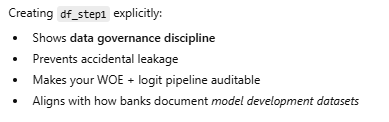

feature_engineering_woe.

## Step 3: Weight of Evidence (WOE) Feature Engineering

The objective of this step is to transform raw borrower and loan attributes into
a model-ready, interpretable feature space using Weight of Evidence (WOE).

WOE encoding is the industry standard for Probability of Default (PD) modeling
because it:
- Produces monotonic relationships with default risk
- Places all variables on a log-odds scale
- Preserves interpretability of logistic regression coefficients
- Supports regulatory explainability and scorecard-style analysis

WOE binning and mappings are learned **only on the training dataset** to avoid
information leakage.


Variable Type Segmentation

## 3.1 Variable Type Segmentation

Before applying WOE, variables are explicitly segmented into:
- Numeric variables (continuous or discrete)
- Categorical variables (nominal / ordinal)

This separation is critical because numeric and categorical variables require
different binning and WOE calculation strategies.

The target variable (`default_flag`) and outcome-related fields are excluded.


In [ ]:
# identify numeric and categorical tables
# identify numeric and categorical variables
target = "default_flag"

numeric_vars = df_step1.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_vars = [v for v in numeric_vars if v != target]

categorical_vars = df_step1.select_dtypes(include=["object"]).columns.tolist()

numeric_vars, categorical_vars


(['loan_amnt',
  'int_rate',
  'installment',
  'annual_inc',
  'dti',
  'emp_length',
  'open_acc',
  'revol_bal',
  'revol_util',
  'total_acc',
  'inq_last_6mths',
  'delinq_2yrs'],
 ['term', 'sub_grade', 'verification_status', 'home_ownership', 'purpose'])

Train/Test Split ( Governance Rule)

## 3.2 Train / Test Split

The dataset is split into training and test samples prior to WOE calculation.

This is a critical governance requirement:
- WOE bins and mappings must be derived using **training data only**
- Applying bins learned on the full dataset would introduce target leakage
- The test set must remain a true out-of-sample validation

A stratified split is used to preserve the default rate across samples.


In [ ]:
from sklearn.model_selection import train_test_split

X = df_step1[numeric_vars + categorical_vars]
y = df_step1[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(y_train.mean(), y_test.mean())


0.19964958667155122 0.19965064853012227


Preserve Raw Data for Business Analysis

We keep raw copies of the train and test sets before WOE encoding so model outputs can later be analyzed using original business variables (e.g., grade, term).

In [ ]:
df_train_raw = df_step1.loc[X_train.index].copy()
df_test_raw  = df_step1.loc[X_test.index].copy()


## 3.3 WOE Binning Methodology

Two WOE strategies are applied:

### Numeric Variables
- Quantile-based binning (`qcut`)
- Ensures sufficient observations per bin
- Produces ordered bins suitable for monotonic risk inspection

### Categorical Variables
- Categories are grouped directly
- Missing values are treated explicitly as a separate category ("MISSING")

At this stage, no bin merging or monotonicity enforcement is applied.
These refinements are addressed during model validation.


## 3.4 WOE Calculation: Numeric Variables

For numeric variables, WOE is calculated as:

WOE = ln(% Non-Defaults in Bin / % Defaults in Bin)

Each bin represents a range of the original variable.
Higher WOE values indicate lower relative default risk, and vice versa.


In [ ]:
def woe_numeric(series, target, bins=10):
    df = pd.DataFrame({"x": series, "y": target})

    df["bin"] = pd.qcut(df["x"], q=bins, duplicates="drop")

    grouped = df.groupby("bin", observed=True)["y"]

    good = grouped.count() - grouped.sum()
    bad  = grouped.sum()

    dist_good = good / good.sum()
    dist_bad  = bad / bad.sum()

    woe = np.log(dist_good / dist_bad)

    woe_df = pd.DataFrame({
        "bin": woe.index,      # ✅ KEEP AS Interval objects
        "woe": woe.values
    })

    return woe_df


In [ ]:
#Sanity Check

woe_numeric(X_train["loan_amnt"], y_train)


,bin,woe
0,"(499.999, 5000.0]",0.290323
1,"(5000.0, 6500.0]",0.272720
2,"(6500.0, 8675.0]",0.208212
3,"(8675.0, 10000.0]",0.106994
4,"(10000.0, 12000.0]",-0.035354
5,"(12000.0, 15000.0]",-0.067101
6,"(15000.0, 18000.0]",-0.164675
7,"(18000.0, 21000.0]",-0.163225
8,"(21000.0, 28000.0]",-0.145705
9,"(28000.0, 40000.0]",-0.260127


In [ ]:
def apply_woe_numeric_clean(series, woe_df):
    woe_series = pd.Series(index=series.index, dtype=float)

    for interval, woe_val in zip(woe_df["bin"], woe_df["woe"]):
        woe_series.loc[
            series.between(interval.left, interval.right, inclusive="right")
        ] = woe_val

    return woe_series


In [ ]:
import inspect
print(inspect.getsource(apply_woe_numeric))


NameError: name 'apply_woe_numeric' is not defined

In [ ]:
# Build WOE maps

woe_maps_numeric = {}

for var in numeric_vars:
    woe_maps_numeric[var] = woe_numeric(X_train[var], y_train)


In [ ]:
# apply WOE to numerical variables

X_train_woe = pd.DataFrame(index=X_train.index)
X_test_woe  = pd.DataFrame(index=X_test.index)

for var in numeric_vars:
    X_train_woe[var] = apply_woe_numeric_clean(X_train[var], woe_maps_numeric[var])
    X_test_woe[var]  = apply_woe_numeric_clean(X_test[var],  woe_maps_numeric[var])


## 3.5 WOE Calculation: Categorical Variables

For categorical variables, WOE is calculated at the category level.

Each category is treated as its own bin, with missing values handled explicitly.
This allows the model to learn risk differences across borrower segments,
loan purposes, or application types in an interpretable way.


In [ ]:
def woe_categorical(series, target):
    df = pd.DataFrame({
        "x": series.fillna("MISSING"),
        "y": target
    })

    grouped = df.groupby("x")["y"]

    good = grouped.count() - grouped.sum()
    bad  = grouped.sum()

    dist_good = good / good.sum()
    dist_bad  = bad / bad.sum()

    woe = np.log(dist_good / dist_bad)

    return pd.DataFrame({
        "category": woe.index,
        "woe": woe.values
    })


In [ ]:
woe_maps_categorical = {}

for var in categorical_vars:
    woe_maps_categorical[var] = woe_categorical(X_train[var], y_train)


## 3.6 WOE Mapping Storage

WOE mappings for each variable are stored as lookup tables.
These mappings serve as:
- The transformation logic applied to training and test datasets
- Artifacts required for model governance and reproducibility
- Inputs for downstream scorecard or Power BI reporting

No transformation is applied yet at this stage.


In [ ]:
#categorical

def apply_woe_categorical(series, woe_df):
    woe_map = dict(zip(woe_df["category"], woe_df["woe"]))
    return series.fillna("MISSING").map(woe_map)


## 3.7 Applying WOE Transformations

Using the stored WOE mappings, both the training and test datasets are transformed
into WOE space.

Key principles:
- Training and test data use identical WOE mappings
- No recalculation occurs on the test set
- The resulting datasets are fully numeric and model-ready


In [ ]:
X_train_woe = pd.DataFrame(index=X_train.index)
X_test_woe  = pd.DataFrame(index=X_test.index)

for var in numeric_vars:
    X_train_woe[var] = apply_woe_numeric_clean(X_train[var], woe_maps_numeric[var])
    X_test_woe[var]  = apply_woe_numeric_clean(X_test[var],  woe_maps_numeric[var])

for var in categorical_vars:
    X_train_woe[var] = apply_woe_categorical(X_train[var], woe_maps_categorical[var])
    X_test_woe[var]  = apply_woe_categorical(X_test[var],  woe_maps_categorical[var])


## Step 4: Logistic Regression PD Model

This step fits a logistic regression model using WOE-transformed variables
to estimate the Probability of Default (PD).

Because all predictors are expressed in WOE (log-odds) space:
- Coefficients are directly interpretable
- Signs indicate direction of risk contribution
- Model outputs are suitable for regulatory and business use


In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000
)

logit.fit(X_train_woe, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
X_train_woe.isna().mean().sort_values(ascending=False).head(15)


,0
loan_amnt,0.0
int_rate,0.0
installment,0.0
annual_inc,0.0
dti,0.0
emp_length,0.0
open_acc,0.0
revol_bal,0.0
revol_util,0.0
total_acc,0.0


In [ ]:
X_test_woe.isna().mean().sort_values(ascending=False).head(15)


,0
annual_inc,0.000002
loan_amnt,0.000000
int_rate,0.000000
installment,0.000000
dti,0.000000
emp_length,0.000000
open_acc,0.000000
revol_bal,0.000000
revol_util,0.000000
total_acc,0.000000


In [ ]:
X_train_woe_filled = X_train_woe.fillna(0)
X_test_woe_filled  = X_test_woe.fillna(0)


In [ ]:
# predict PD
pd_train = logit.predict_proba(X_train_woe_filled)[:, 1]
pd_test  = logit.predict_proba(X_test_woe_filled)[:, 1]


In [ ]:
# Model Performance- AUC

from sklearn.metrics import roc_auc_score

auc_train = roc_auc_score(y_train, pd_train)
auc_test  = roc_auc_score(y_test, pd_test)

auc_train, auc_test


(np.float64(0.7092255119442066), np.float64(0.7086272776952652))

In [ ]:
# Model Performance KS Statistic

import numpy as np

def ks_stat(y_true, y_pred):
    df = pd.DataFrame({"y": y_true, "p": y_pred})
    df = df.sort_values("p")

    df["cum_bad"] = df["y"].cumsum() / df["y"].sum()
    df["cum_good"] = (1 - df["y"]).cumsum() / (1 - df["y"]).sum()

    return np.max(np.abs(df["cum_bad"] - df["cum_good"]))

ks_train = ks_stat(y_train, pd_train)
ks_test  = ks_stat(y_test, pd_test)

ks_train, ks_test


(0.303004809147497, 0.3011429684128356)

In consumer credit:

KS ≈ 30–40 → solid

KS > 40 → strong

KS < 25 → weak

so this performance can be rated solid

In [ ]:
# Coefficient Interpretation

coef_df = pd.DataFrame({
    "variable": X_train_woe.columns,
    "coefficient": logit.coef_[0]
}).sort_values("coefficient")

coef_df.head(10), coef_df.tail(10)


(          variable  coefficient
 9        total_acc    -1.462175
 6         open_acc    -1.369537
 11     delinq_2yrs    -1.084658
 13       sub_grade    -0.962511
 15  home_ownership    -0.878323
 5       emp_length    -0.840727
 7        revol_bal    -0.771273
 3       annual_inc    -0.675889
 2      installment    -0.554322
 12            term    -0.484566,
                variable  coefficient
 3            annual_inc    -0.675889
 2           installment    -0.554322
 12                 term    -0.484566
 4                   dti    -0.459372
 10       inq_last_6mths    -0.358092
 14  verification_status    -0.234899
 16              purpose    -0.186040
 8            revol_util    -0.080357
 0             loan_amnt    -0.049744
 1              int_rate     0.227230)

“The majority of predictors exhibit negative coefficients, indicating that higher
WOE values (associated with lower-risk borrower profiles) reduce predicted default
probability. Interest rate displays a positive coefficient, consistent with its role
as a risk-based pricing variable associated with elevated default risk.”

In [ ]:
# sanity check

woe_maps_numeric["annual_inc"]


,bin,woe
0,"(-0.001, 34000.0]",-0.236978
1,"(34000.0, 42000.0]",-0.179720
2,"(42000.0, 50000.0]",-0.115099
3,"(50000.0, 57000.0]",-0.072086
4,"(57000.0, 65000.0]",-0.052158
5,"(65000.0, 74000.0]",0.019996
6,"(74000.0, 85000.0]",0.067017
7,"(85000.0, 100000.0]",0.141189
8,"(100000.0, 125000.0]",0.235765
9,"(125000.0, 9550000.0]",0.334542


Risk Bands (PD Deciles)
What this answers

“Can the model meaningfully rank borrowers from safest to riskiest?”

In [ ]:
pd_df = pd.DataFrame({
    "pd": pd_test,
    "default": y_test
})

pd_df["pd_decile"] = pd.qcut(pd_df["pd"], 10, labels=False) + 1


Default Rate by PD Band

In [ ]:
band_perf = (
    pd_df
    .groupby("pd_decile")
    .agg(
        avg_pd=("pd", "mean"),
        default_rate=("default", "mean"),
        obs=("default", "count")
    )
    .reset_index()
)

band_perf


,pd_decile,avg_pd,default_rate,obs
0,1,0.044921,0.041401,40361
1,2,0.078408,0.078221,40360
2,3,0.105706,0.102872,40361
3,4,0.132391,0.135877,40360
4,5,0.160931,0.162360,40361
5,6,0.192063,0.196853,40360
6,7,0.227309,0.229782,40360
7,8,0.270007,0.272813,40361
8,9,0.329746,0.326487,40360
9,10,0.454195,0.449840,40361


“When we break the portfolio into PD bands, the story is very clean. Defaults start around 4% in the safest group and rise steadily to about 45% in the riskiest group, with no odd jumps in between. That tells us the model is ranking risk the way we’d expect and that the predicted PDs line up closely with what actually happens, and also the predictions are well aligned with real outcomes, suggesting the model is not only ranking risk correctly but also reasonably calibrated..”

#Approval threshold discussion

In [ ]:
cutoff = 0.15
pd_df["approved"] = (pd_df["pd"] <= cutoff).astype(int)


In [ ]:
approval_rate = pd_df["approved"].mean()
portfolio_default_rate = pd_df["default"].mean()
approved_default_rate = pd_df.loc[pd_df["approved"] == 1, "default"].mean()

approval_summary = pd.DataFrame({
    "metric": [
        "Approval rate",
        "Overall portfolio default rate",
        "Approved population default rate"
    ],
    "value": [
        approval_rate,
        portfolio_default_rate,
        approved_default_rate
    ]
})

approval_summary


,metric,value
0,Approval rate,0.413204
1,Overall portfolio default rate,0.199651
2,Approved population default rate,0.091563


At the selected PD cutoff, approximately 41% of applicants are approved. The overall portfolio exhibits a default rate of about 20%, while the approved population’s default rate falls to roughly 9%. This demonstrates a clear trade-off between approval volume and credit quality, where tighter risk thresholds significantly reduce expected defaults at the cost of lower approval rates.

This analysis highlights how the PD model can be used to support practical underwriting decisions by balancing growth objectives against risk tolerance.

Approval vs Loss Trade-off
Applying a PD-based approval threshold materially improves portfolio quality. At the selected cutoff, approximately 41% of applicants are approved, reducing the default rate from roughly 20% in the overall applicant pool to about 9% in the approved population. Tightening the threshold further would continue to reduce losses at the cost of lower approval volume, while loosening it would support growth but increase expected defaults. The model provides a transparent framework for balancing risk appetite against growth objectives rather than prescribing a single optimal decision.

Expected Loss Framework (Portfolio Insight)

We’ll use a simple, defensible assumption:

LGD = 60% (industry-reasonable for unsecured consumer loans)

EAD = 1 (normalized exposure)

In [ ]:
LGD = 0.60
pd_df["EL"] = pd_df["pd"] * LGD


Which Segments drive expected Loss

Expected Loss by Grade

In [ ]:
segment_df = df_test_raw.copy()



In [ ]:
segment_df["pd"] = pd_test
segment_df["default"] = y_test
LGD = 0.60
segment_df["EL"] = segment_df["pd"] * LGD


In [ ]:
segment_df = df_test_raw.copy()

segment_df["pd"] = pd_test
segment_df["default"] = y_test
LGD = 0.60
segment_df["EL"] = segment_df["pd"] * LGD

el_by_subgrade = (
    segment_df
    .groupby("sub_grade")
    .agg(
        avg_pd=("pd", "mean"),
        default_rate=("default", "mean"),
        avg_el=("EL", "mean"),
        loans=("pd", "count")
    )
    .sort_values("avg_el", ascending=False)
)

el_by_subgrade


,avg_pd,default_rate,avg_el,loans
sub_grade,,,,
G5,0.571115,0.516340,0.342669,306
G4,0.555390,0.496104,0.333234,385
G3,0.535997,0.541667,0.321598,504
G1,0.521632,0.445931,0.312979,897
G2,0.516033,0.494290,0.309620,613
F5,0.513876,0.503361,0.308326,1190
F4,0.505581,0.479971,0.303348,1398
F2,0.478641,0.451034,0.287185,2175
F3,0.475900,0.446399,0.285540,1819


“Expected loss is most concentrated in lower sub-grades, particularly G and F segments, where default probabilities exceed 50%. While G grades are primarily risk-driven, mid-tier grades such as F and E also contribute materially to portfolio loss due to higher loan volumes. This suggests that loss mitigation strategies should focus not only on excluding the riskiest borrowers, but also on managing exposure and pricing within mid-risk segments.”

Grade × Term expected loss

This answers:

“Is longer tenure amplifying loss in risky grades?

In [ ]:
#Make sure grade exists

segment_df["grade"] = segment_df["sub_grade"].str[0]

In [ ]:
# Expected Loss by Grade and Term

grade_term_el = (
    segment_df
    .groupby(["grade", "term"])
    .agg(
        avg_pd=("pd", "mean"),
        default_rate=("default", "mean"),
        avg_el=("EL", "mean"),
        loans=("pd", "count")
    )
    .reset_index()
    .sort_values(["grade", "term"])
)

grade_term_el


,grade,term,avg_pd,default_rate,avg_el,loans
0,A,36 months,0.062994,0.059505,0.037796,68683
1,A,60 months,0.104675,0.103719,0.062805,1909
2,B,36 months,0.127126,0.127898,0.076276,103489
3,B,60 months,0.171947,0.183153,0.103168,14365
4,C,36 months,0.203361,0.204597,0.122017,82929
5,C,60 months,0.273256,0.276403,0.163954,31928
6,D,36 months,0.265272,0.269435,0.159163,37638
7,D,60 months,0.352548,0.362095,0.211529,22414
8,E,36 months,0.331206,0.324867,0.198724,10749
9,E,60 months,0.427837,0.420446,0.256702,17177


pivot for readability

In [ ]:
grade_term_pivot = grade_term_el.pivot(
    index="grade",
    columns="term",
    values="avg_el"
)

grade_term_pivot


term,36 months,60 months
grade,,
A,0.037796,0.062805
B,0.076276,0.103168
C,0.122017,0.163954
D,0.159163,0.211529
E,0.198724,0.256702
F,0.238883,0.298183
G,0.269471,0.330189


Loan term amplifies credit risk, and the amplification effect is strongest in lower credit grades.

Expected loss increases both as borrower credit quality deteriorates and as loan tenor lengthens. While longer terms modestly increase risk for high-quality borrowers, the impact is much more pronounced in lower grades, where 60-month loans exhibit materially higher expected loss. This suggests that term length acts as a risk amplifier rather than an independent driver of risk.

exporting to csv

In [ ]:
export_df = segment_df[[
    "pd",
    "default",
    "grade",
    "sub_grade",
    "term",
    "loan_amnt",
    "int_rate",
    "annual_inc",
    "dti",
    "EL"
]].copy()


In [ ]:
export_df.to_csv(
    "consumer_loans_scored.csv",
    index=False
)


In [63]:
from google.colab import files

files.download("consumer_loans_scored.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>